In [7]:
import numpy as np
import scipy.ndimage
import scipy.interpolate
import skimage.io
import matplotlib.pyplot as plt

import maxflow
import scipy.linalg
import skimage.draw
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 

In [8]:
def make_circular_snake(N, center, radius):
    """ Initialize circular snake as a 2-by-N array."""
    center = center.reshape([2,1])
    angles = np.arange(N)*2*np.pi/N
    return(center+radius*np.array([np.cos(angles), np.sin(angles)]))


def normalize(n):
    return n/np.sqrt(np.sum(n**2,axis=0))


def snake_normals(snake):
    """ Returns snake normals. Expects snake to be 2-by-N array."""
    ds = normalize(np.roll(snake, 1, axis=1) - snake) # (roll shifts the points) get the displacement ds between 2 consecutive points
    tangent = normalize(np.roll(ds,-1,axis=1) + ds) # set tangent as the mean between 2 consecutive displacement
    normal = tangent[[1,0],:] * np.array([-1,1]).reshape([2,1]) # normal is perpendicular to the mean
    return(normal)


## Provided functions
def distribute_points(snake):
    """ Distributes snake points equidistantly. Expects snake to be 2-by-N array."""
    N = snake.shape[1]
    d = np.sqrt(np.sum((np.roll(snake, -1, axis=1)-snake)**2, axis=0)) # length of line segments
    f = scipy.interpolate.interp1d(np.r_[0, np.cumsum(d)], np.c_[snake, snake[:,0:1]])
    return(f(sum(d)*np.arange(N)/N))


def is_crossing(p1, p2, p3, p4):
    """ Check if the line segments (p1, p2) and (p3, p4) cross."""
    crossing = False
    d21 = p2 - p1
    d43 = p4 - p3
    d31 = p3 - p1
    det = d21[0]*d43[1] - d21[1]*d43[0] # Determinant
    if det != 0.0 and d21[0] != 0.0 and d21[1] != 0.0:
        a = d43[0]/d21[0] - d43[1]/d21[1]
        b = d31[1]/d21[1] - d31[0]/d21[0]
        if a != 0.0:
            u = b/a
            if d21[0] > 0:
                t = (d43[0]*u + d31[0])/d21[0]
            else:
                t = (d43[1]*u + d31[1])/d21[1]
            crossing = 0 < u < 1 and 0 < t < 1         
    return crossing


def is_counterclockwise(snake):
    """ Check if points are ordered counterclockwise."""
    return np.dot(snake[0,1:] - snake[0,:-1],
                  snake[1,1:] + snake[1,:-1]) < 0


def remove_intersections(snake):
    """ Reorder snake points to remove self-intersections.
        Arguments: snake represented by a 2-by-N array.
        Returns: snake.
    """
    pad_snake = np.append(snake, snake[:,0].reshape(2,1), axis=1)
    pad_n = pad_snake.shape[1]
    n = pad_n - 1 
    
    for i in range(pad_n - 3):
        for j in range(i + 2, pad_n - 1):
            pts = pad_snake[:,[i, i + 1, j, j + 1]]
            if is_crossing(pts[:,0], pts[:,1], pts[:,2], pts[:,3]):
                # Reverse vertices of smallest loop
                rb = i + 1 # Reverse begin
                re = j     # Reverse end
                if j - i > n // 2:
                    # Other loop is smallest
                    rb = j + 1
                    re = i + n                    
                while rb < re:
                    ia = rb % n
                    rb = rb + 1                    
                    ib = re % n
                    re = re - 1                    
                    pad_snake[:,[ia, ib]] = pad_snake[:,[ib, ia]]                    
                pad_snake[:,-1] = pad_snake[:,0]                
    snake = pad_snake[:,:-1]
    if is_counterclockwise(snake):
        return snake
    else:
        return np.flip(snake, axis=1)
## end provided function
    
def keep_snake_inside(snake, shape):
    """ Contains snake insite the image."""
    snake[snake<0]=0
    snake[0][snake[0]>shape[0]-1] = shape[0]-1 
    snake[1][snake[1]>shape[1]-1] = shape[1]-1 
    return snake

    
def regularization_matrix(N, alpha, beta):
    """ Matrix for smoothing the snake."""
    d = alpha*np.array([-2, 1, 0, 0]) + beta*np.array([-6, 4, -1, 0])
    D = np.fromfunction(lambda i,j: np.minimum((i-j)%N,(j-i)%N), (N,N), dtype=int)
    A = d[np.minimum(D,len(d)-1)]
    return(scipy.linalg.inv(np.eye(N)-A))


def evolve_snake(snake, I, B, step_size):
    """ Single step of snake evolution."""
    footprint = disk(5)
    
    # Compute mean intensities inside and outside the snake.
    mask = skimage.draw.polygon2mask(I.shape, snake.T)
    eroded = erosion(mask, footprint)
    mask = np.logical_xor(mask,eroded)
    patch = np.ones(I.shape)*2
    minsnake = np.min(snake,axis=1).astype(int)
    maxsnake = np.max(snake,axis=1).astype(int)
    patch[minsnake[0]-5:maxsnake[0]+5,minsnake[1]-5:maxsnake[1]+5] = mask[minsnake[0]-5:maxsnake[0]+5,minsnake[1]-5:maxsnake[1]+5]
    
    m_in = np.mean(I[mask==1])
    m_out = np.mean(I[mask==0])
    
    # Compute the magnitude of the snake displacement given by Eq. (6.1)
    f = scipy.interpolate.RectBivariateSpline(np.arange(I.shape[0]), np.arange(I.shape[1]), I)
    val = f(snake[0],snake[1], grid=False)
    # val = I[snake[0].astype(int), snake[1].astype(int)] # simpler variant without interpolation
    force = 0.5*(m_in-m_out)*(2*val - (m_in+m_out))
    
    
    snake += step_size*force*snake_normals(snake) # external part
    
    snake = np.dot(snake, B) # internal part, ordering influenced by 2-by-N representation of snake
    
    snake = remove_intersections(snake)
    snake = distribute_points(snake)
    snake = keep_snake_inside(snake, I.shape)
    return snake

In [9]:
# Load data
im = skimage.io.imread('nerves_part.tiff')/255

In [10]:
%matplotlib qt

### Multiple snakes visualization

In [5]:
#%% settings
nr_points = 100
step_size = 70
alpha = 3
beta = 10
#center = np.array([[261, 132], [214, 167], [208, 214]])
#radius = np.array([25, 25, 20])
center = np.array([[114, 171],[226, 93], [261, 132], [214, 167], [208, 214]])
radius = np.array([20, 20, 25, 25, 20])
n = len(radius)
footprint = disk(7) # surface thikness would be 7 px large on the picture

#%% initialization
frame = im[0]
fig, ax = plt.subplots()
ax.imshow(frame, cmap='gray')
SNAKES = np.zeros((n,2,nr_points))
for i in range(n):
    SNAKES[i,:,:] = make_circular_snake(nr_points, center[i], radius[i])
    B = regularization_matrix(nr_points, alpha, beta)
    ax.plot(np.r_[SNAKES[i,:,:][1],SNAKES[i,:,:][1,0]],np.r_[SNAKES[i,:,:][0],SNAKES[i,:,:][0,0]])

In [6]:
for i in range(30): 
    ax.clear()
    ax.imshow(frame, cmap='gray')
    for j in range(n):
        SNAKES[j,:,:] = evolve_snake(SNAKES[j,:,:], frame, B, step_size)    
        ax.plot(np.r_[SNAKES[j,:,:][1],SNAKES[j,:,:][1,0]],np.r_[SNAKES[j,:,:][0],SNAKES[j,:,:][0,0]])
    ax.set_title(f'initialization, iter {i}')
    plt.pause(0.001)

In [7]:
#%% tracking
for i in range(0,100):
    frame = im[i] 
    ax.clear()
    ax.imshow(frame, cmap='gray')
    for j in range(n):
        SNAKES[j,:,:] = evolve_snake(SNAKES[j,:,:], frame, B, step_size) 
        ax.plot(np.r_[SNAKES[j,:,:][1],SNAKES[j,:,:][1,0]],np.r_[SNAKES[j,:,:][0],SNAKES[j,:,:][0,0]])
    ax.set_title(f'tracking, frame {i}')
    plt.pause(0.0001)

### Single snake visualization

In [11]:

#%% settings
nr_points = 100
step_size = 70
alpha = 1
beta = 1.5
center = np.array([226, 93])
radius = 30
footprint = disk(7)

#%% initialization
snake = make_circular_snake(nr_points, center, radius)
B = regularization_matrix(nr_points, alpha, beta)
frame = im[0]
fig, ax = plt.subplots()
ax.imshow(frame, cmap='gray')
ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'b-')

for i in range(30):    
    snake = evolve_snake(snake, frame, B, step_size)    
    ax.clear()
    ax.imshow(frame, cmap='gray')
    ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'b-')
    ax.set_title(f'initialization, iter {i}')
    plt.pause(0.001)



In [12]:
snake

array([[251.10032254, 250.50759528, 249.79158607, 248.96665376,
        248.02629061, 246.99184022, 245.95297971, 244.95635655,
        243.99468175, 242.9943216 , 241.9423945 , 240.87169148,
        239.81546276, 238.7601617 , 237.60405034, 236.28482007,
        234.92079023, 233.52214328, 232.06544624, 230.58172215,
        229.06454571, 227.48073239, 225.87059147, 224.2614443 ,
        222.64512564, 221.02405776, 219.40337276, 217.77987115,
        216.15421587, 214.51958339, 212.88027496, 211.24392913,
        209.61523947, 208.0015496 , 206.43824677, 204.95312182,
        203.51901218, 202.10379735, 200.70561825, 199.41232194,
        198.33328117, 197.52345036, 196.86794376, 196.21764349,
        195.59396839, 195.1739516 , 195.04580675, 195.27939629,
        195.84499951, 196.53642842, 197.31834746, 198.12274385,
        198.98952857, 199.94770575, 200.89182479, 201.75500711,
        202.54463969, 203.36132932, 204.25952327, 205.24677193,
        206.30037026, 207.41096031, 208.

In [ ]:
#%% tracking
for i in range(0,500):
    frame = im[i] 
    snake = evolve_snake(snake, frame, B, step_size) 
    ax.clear()
    ax.imshow(frame, cmap='gray')
    ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'b-')
    ax.set_title(f'tracking, frame {i}')
    plt.pause(0.0001)

### Single snake save 3D segmentation

In [9]:
#%% settings
nr_points = 100
step_size = 70
alpha = 3
beta = 10
center = np.array([261, 132])
radius = 25
footprint = disk(7)

#%% initialization
snake = make_circular_snake(nr_points, center, radius)
B = regularization_matrix(nr_points, alpha, beta)
frame = im[0]
fig, ax = plt.subplots()
ax.imshow(frame, cmap='gray')
ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'b-')


SNAKESIM = np.zeros((350,350,500))
for i in range(30):    
    snake = evolve_snake(snake, frame, B, step_size)    
    ax.clear()
    ax.imshow(frame, cmap='gray')
    ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'b-')
    ax.set_title(f'initialization, iter {i}')
    plt.pause(0.001)
    
snakeim = skimage.draw.polygon2mask((350,350), snake.T)
eroded = erosion(snakeim, footprint)
snakeim = np.logical_xor(snakeim,eroded)
SNAKESIM[:,:,0] = snakeim

In [10]:
#%% tracking
for i in range(0,500):
    frame = im[i] 
    snake = evolve_snake(snake, frame, B, step_size) 
    snakeim = skimage.draw.polygon2mask((350,350), snake.T)
    eroded = erosion(snakeim, footprint)
    snakeim = np.logical_xor(snakeim,eroded)
    SNAKESIM[:,:,i] = snakeim

In [84]:
plt.imshow(SNAKESIM[:,:,300])


In [11]:
test = SNAKESIM*255
test = test.astype('uint8')
skimage.io.imsave('snake2.tiff', test)

/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_51342/234830002.py:3: UserWarning: snake2.tiff is a low contrast image
  skimage.io.imsave('snake2.tiff', test)


### Multiple snakes save 3D segmentation

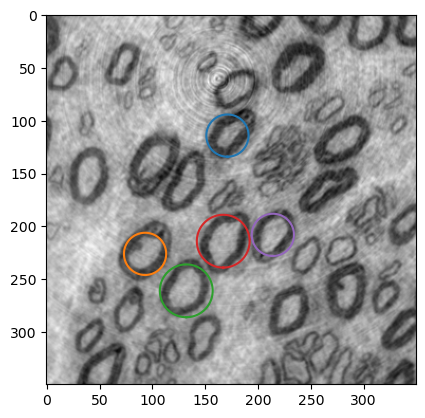

In [6]:
#%% settings
nr_points = 100
step_size = 70
alpha = 3
beta = 10
center = np.array([[114, 171],[226, 93], [261, 132], [214, 167], [208, 214]])
radius = np.array([20, 20, 25, 25, 20])
n = len(radius)
nslice = 1024
footprint = disk(7) # surface thikness would be 7 px large on the picture

#%% initialization
frame = im[0]
fig, ax = plt.subplots()
ax.imshow(frame, cmap='gray')
SNAKES = np.zeros((n,2,nr_points))
for i in range(n):
    SNAKES[i,:,:] = make_circular_snake(nr_points, center[i], radius[i])
    B = regularization_matrix(nr_points, alpha, beta)
    ax.plot(np.r_[SNAKES[i,:,:][1],SNAKES[i,:,:][1,0]],np.r_[SNAKES[i,:,:][0],SNAKES[i,:,:][0,0]])

In [7]:
SNAKESIMS = np.zeros((350,350,nslice,n))
SNAKESIMSFULL = np.zeros((350,350,nslice,n))
for i in range(30): 
    ax.clear()
    ax.imshow(frame, cmap='gray')
    for j in range(n):
        SNAKES[j,:,:] = evolve_snake(SNAKES[j,:,:], frame, B, step_size)    
        ax.plot(np.r_[SNAKES[j,:,:][1],SNAKES[j,:,:][1,0]],np.r_[SNAKES[j,:,:][0],SNAKES[j,:,:][0,0]])
    ax.set_title(f'initialization, iter {i}')
    plt.pause(0.001)

for j in range(n):
    snakeim = skimage.draw.polygon2mask((350,350), SNAKES[j,:,:].T)
    SNAKESIMSFULL[:,:,0,j] = snakeim
    eroded = erosion(snakeim, footprint)
    snakeim = np.logical_xor(snakeim,eroded)
    SNAKESIMS[:,:,0,j] = snakeim

In [8]:
#%% tracking
for i in range(0,nslice):
    frame = im[i] 
    for j in range(n):
        SNAKES[j,:,:] = evolve_snake(SNAKES[j,:,:], frame, B, step_size) 
        snakeim = skimage.draw.polygon2mask((350,350), SNAKES[j,:,:].T)
        SNAKESIMSFULL[:,:,i,j] = snakeim
        eroded = erosion(snakeim, footprint)
        snakeim = np.logical_xor(snakeim,eroded)
        SNAKESIMS[:,:,i,j] = snakeim


In [10]:
for j in range(n):
    test = SNAKESIMSFULL[:,:,:,j]*255
    test = test.astype('uint8')
    print(f'snakefull{j}.tiff')
    skimage.io.imsave(f'snakefull{j}.tiff', test)

snakefull0.tiff
snakefull1.tiff
snakefull2.tiff
snakefull3.tiff
snakefull4.tiff


In [24]:
for j in range(n):
    test = SNAKESIMS[:,:,:,j]*255
    test = test.astype('uint8')
    print(f'snake{j}.tiff')
    skimage.io.imsave(f'snake{j}.tiff', test)

snake0.tiff


/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_51342/761412353.py:5: UserWarning: snake0.tiff is a low contrast image
  skimage.io.imsave(f'snake{j}.tiff', test)


snake1.tiff


/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_51342/761412353.py:5: UserWarning: snake1.tiff is a low contrast image
  skimage.io.imsave(f'snake{j}.tiff', test)


snake2.tiff


/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_51342/761412353.py:5: UserWarning: snake2.tiff is a low contrast image
  skimage.io.imsave(f'snake{j}.tiff', test)


snake3.tiff


/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_51342/761412353.py:5: UserWarning: snake3.tiff is a low contrast image
  skimage.io.imsave(f'snake{j}.tiff', test)


snake4.tiff


/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_51342/761412353.py:5: UserWarning: snake4.tiff is a low contrast image
  skimage.io.imsave(f'snake{j}.tiff', test)


In [22]:
# large alpha beta value to prevent snake to merge with periphical nerves
# tricks with the ring 
# patch around the snake

In [9]:
# Average nerve area

In [33]:
S = SNAKESIMSFULL[:,:,:,4]
AREAS = np.zeros(S.shape[2])
for i in range(S.shape[2]):
    AREAS[i] = np.sum(S[:,:,i])

In [34]:
np.mean(AREAS)

1387.048828125

In [35]:
# Average nerve radius

In [37]:
R = np.sqrt(np.mean(AREAS)/np.pi)
R

21.012171582485923